# Final Project Code

### These code snippets are compiled from different jupyter notebooks used throughout the past weeks for various parts of the project

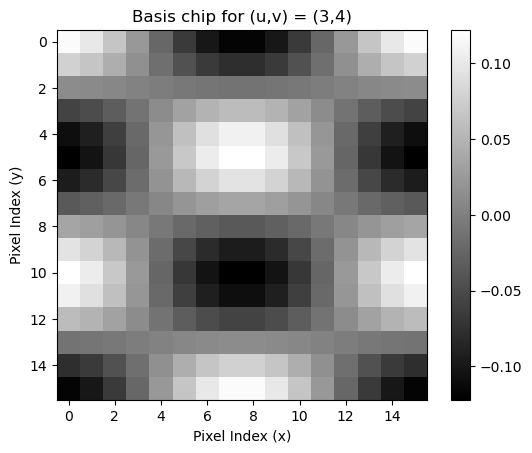

In [2]:
# DCT Chip Construction
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def chip_func(K,u,v):
    if u == 1:
        alpha = np.sqrt(1 / K)
    else:
        alpha = np.sqrt(2 / K)
    if v == 1:
        beta = np.sqrt(1 / K)
    else:
        beta = np.sqrt(2 / K)
    blank_chip =  [[0]*K for _ in range(K)]
    for i in range(K):
        for j in range(K):
            blank_chip[i][j] = alpha * beta * np.cos((np.pi * (2*j + 1) * (u - 1)) / (2 * K)) * np.cos((np.pi * (2*i + 1) * (v - 1))/ (2 * K))
    return blank_chip

plt.axis("on")
plt.imshow(chip_func(16,3,4), cmap='gray')
plt.title("Basis chip for (u,v) = (3,4)")
plt.xlabel("Pixel Index (x)")
plt.ylabel("Pixel Index (y)")
plt.colorbar() 
plt.show()

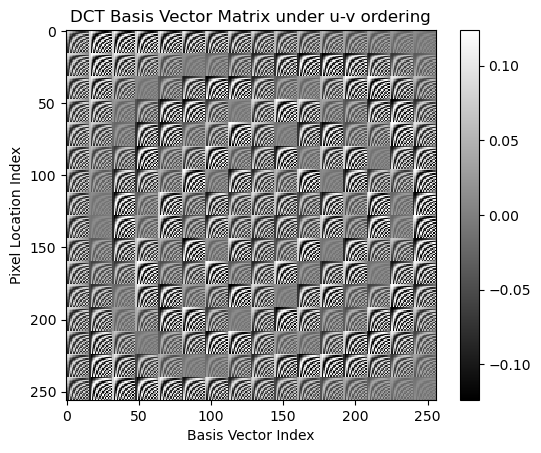

In [ ]:
# DCT BVM Creation
def column(K,u,v):
    if u == 1:
        alpha = np.sqrt(1 / K)
    else:
        alpha = np.sqrt(2 / K)
    if v == 1:
        beta = np.sqrt(1 / K)
    else:
        beta = np.sqrt(2 / K)
    blank_chip =  [[0]*K for _ in range(K)]
    for i in range(K):
        for j in range(K):
            blank_chip[i][j] = alpha * beta * np.cos((np.pi * (2*j + 1) * (u - 1)) / (2 * K)) * np.cos((np.pi * (2*i + 1) * (v - 1))/ (2 * K))
    blank_chip_np = np.array(blank_chip)
    vector = blank_chip_np.reshape(-1, order='F')
    return vector

K = 16
BVM = np.zeros((K*K, K*K))
counter = 0
for u in range(1, K+1):      
    for v in range(1, K+1): 
        BVM[:, counter] = column(K, u, v)
        counter = counter + 1
plt.imshow(BVM, cmap='gray', interpolation='none')
plt.colorbar()
plt.title('DCT Basis Vector Matrix under u-v ordering')
plt.xlabel("Basis Vector Index")
plt.ylabel("Pixel Location Index")
plt.axis("on")
plt.show()

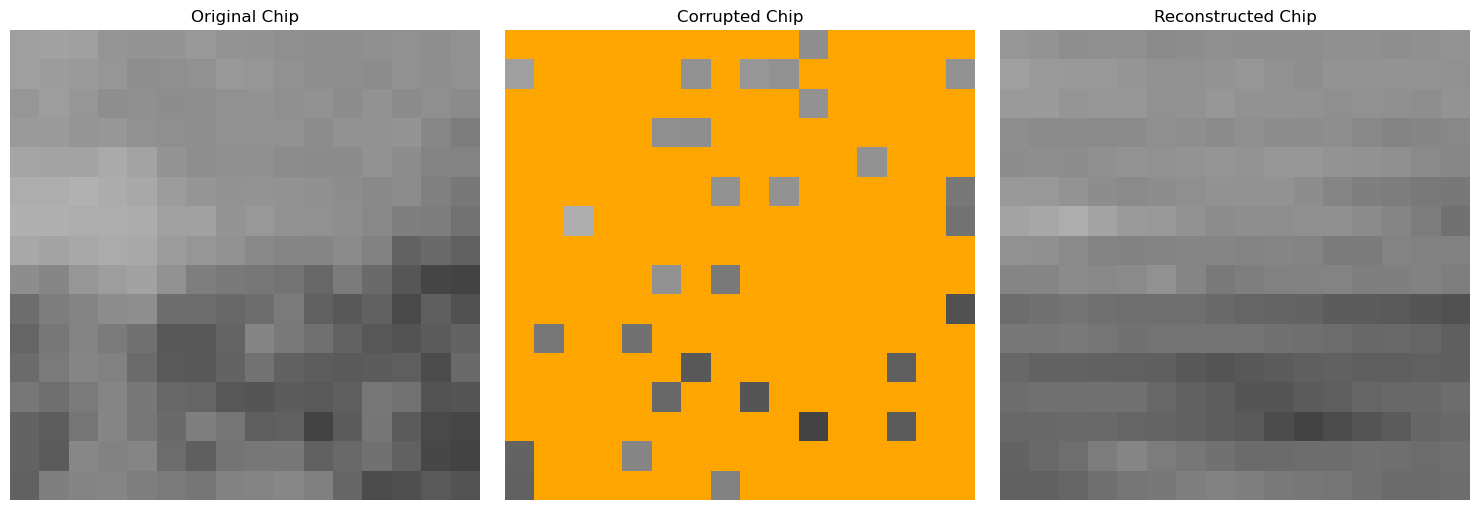

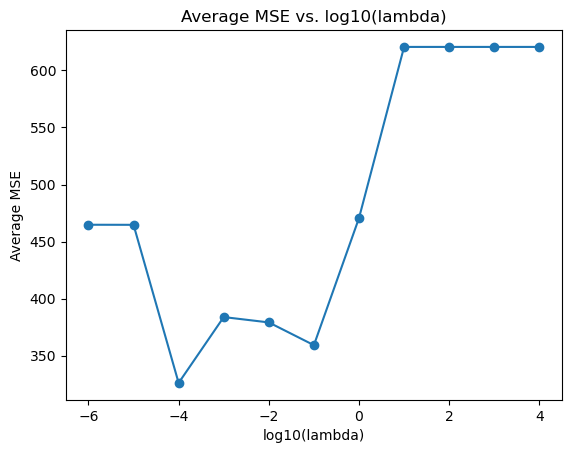

Best lambda: 0.0001


In [ ]:
#Chip corruption and restoration
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from sklearn.linear_model import Lasso
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

original_readin = mpimg.imread('nature.bmp')
original = np.dstack([original_readin, original_readin, original_readin])
K = 16
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]

def column(K, u, v):
    if u == 1:
        alpha = np.sqrt(1 / K)
    else:
        alpha = np.sqrt(2 / K)
    if v == 1:
        beta = np.sqrt(1 / K)
    else:
        beta = np.sqrt(2 / K)
    block = np.zeros((K, K))
    for r in range(K):
        for c in range(K):
            block[r, c] = alpha * beta * np.cos((np.pi * (2*c + 1) * (u - 1)) / (2 * K)) * \
                          np.cos((np.pi * (2*r + 1) * (v - 1)) / (2 * K))
    return block.flatten(order='F')

BVM = np.zeros((K*K, K*K))
counter = 0
for u in range(1, K+1):
    for v in range(1, K+1):
        BVM[:, counter] = column(K, u, v)
        counter += 1

def reconstruct_chip(chip_BW, chip_true, BVM, lambdas):
    col_vector = chip_BW.flatten(order='F').reshape(-1, 1)
    true_vector = chip_true.flatten(order='F').reshape(-1, 1)
    valid_indices = np.where(~np.isnan(col_vector))[0]
    S_valid = len(valid_indices)
    test_size = int(np.floor(S_valid / 6))
    cv = ShuffleSplit(n_splits=20, train_size=S_valid - test_size, test_size=test_size)
    folds = list(cv.split(valid_indices))
    average_MSE_values = [] 
    for lam in lambdas:
        MSE_values = []
        for train_indices, test_indices in folds:
            train = valid_indices[train_indices]
            test  = valid_indices[test_indices]
            BVM_train = BVM[train, :]
            sensed_pixels = col_vector[train].reshape(-1, 1)
            model = Lasso(alpha=lam, fit_intercept=True, max_iter=10000, tol=1e-4)
            model.fit(BVM_train, sensed_pixels)
            coef = model.coef_.copy()
            coef[0] = model.intercept_ / BVM[0, 0]
            preds = np.array([np.dot(BVM[miss, :], coef) for miss in test])
            true_vals = true_vector[test].flatten()
            mse = np.mean((preds - true_vals) ** 2)
            MSE_values.append(mse)
        average_MSE_values.append(np.mean(MSE_values))      
    best_lambda = lambdas[np.argmin(average_MSE_values)]
    BVM_final = BVM[valid_indices, :]
    sensed_pixels_final = col_vector[valid_indices].reshape(-1, 1)
    model = Lasso(alpha=best_lambda, fit_intercept=True, max_iter=10000)
    model.fit(BVM_final, sensed_pixels_final)
    coef = model.coef_.copy()
    coef[0] = model.intercept_ / BVM[0, 0]
    missing = np.where(np.isnan(col_vector))[0]
    for idx in missing:
        col_vector[idx] = np.dot(BVM[idx, :], coef)
    chip_restored = col_vector.reshape((K, K), order='F')
    return chip_restored, best_lambda, average_MSE_values

chip_i = 0  
chip_j = 16 

chip = original[chip_i:chip_i+K, chip_j:chip_j+K].copy()
chip_true = chip[..., 0] 
chip_30sensed = chip.copy()
all_indices = list(range(K*K))
S = 30
random_indices = random.sample(all_indices, (K*K) - S)
for idx in random_indices:
    r, c = np.unravel_index(idx, (K, K))
    chip_30sensed[r, c] = [255, 165, 0]
corrupted_chip = chip_30sensed

chip_BW = np.zeros((K, K))
for r in range(K):
    for c in range(K):
        pixel = chip_30sensed[r, c]
        if pixel[0] == pixel[1] == pixel[2]:
            chip_BW[r, c] = pixel[0]
        else:
            chip_BW[r, c] = np.nan

chip_restored, best_lambda, mse_values = reconstruct_chip(chip_BW, chip_true, BVM, lambdas)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(chip, cmap='gray', vmin=0, vmax=255)
plt.title('Original Chip')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(corrupted_chip, cmap='gray', vmin=0, vmax=255)
plt.title('Corrupted Chip')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(chip_restored, cmap='gray', vmin=0, vmax=255)
plt.title('Reconstructed Chip')
plt.axis('off')
plt.tight_layout()
plt.show()

log_lambdas = np.log10(lambdas)
plt.figure()
plt.plot(log_lambdas, mse_values, marker='o')
plt.xlabel('log10(lambda)')
plt.ylabel('Average MSE')
plt.title('Average MSE vs. log10(lambda)')
plt.show()

print("Best lambda:", best_lambda)

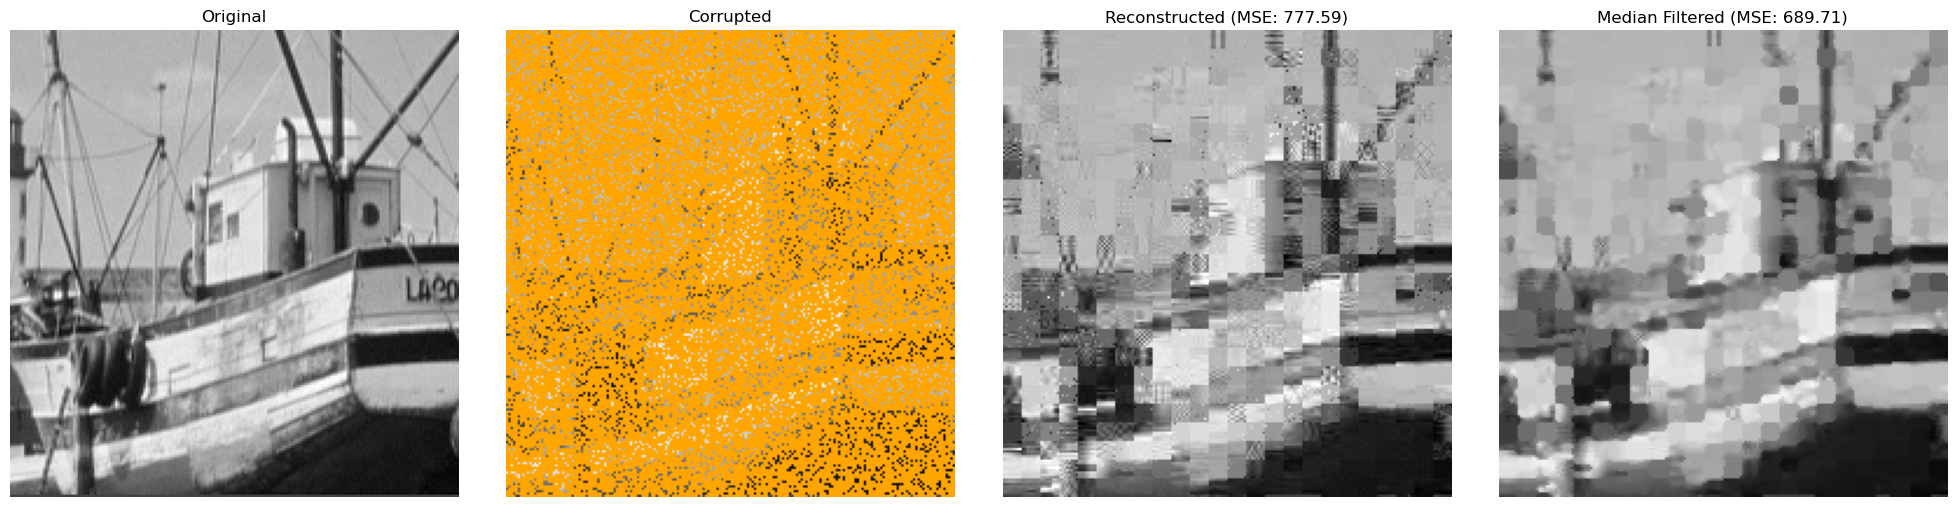

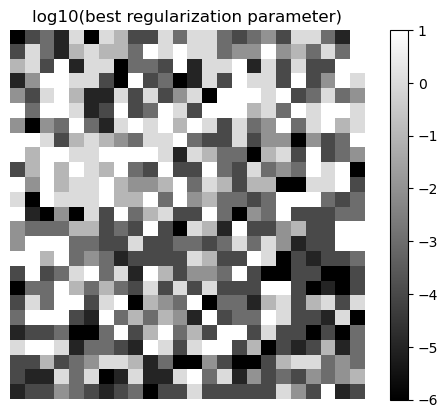

In [ ]:
# Corrupt and reconstruct entire image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
from sklearn.linear_model import Lasso
from sklearn.model_selection import ShuffleSplit
from scipy.ndimage import median_filter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from joblib import Parallel, delayed

original_readin = mpimg.imread('fishing_boat.bmp')
original = np.dstack([original_readin, original_readin, original_readin])
height, width, _ = original.shape
K = 8
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]

def column(K, u, v):
    if u == 1:
        alpha = np.sqrt(1 / K)
    else:
        alpha = np.sqrt(2 / K)
    if v == 1:
        beta = np.sqrt(1 / K)
    else:
        beta = np.sqrt(2 / K)
    block = np.zeros((K, K))
    for r in range(K):
        for c in range(K):
            block[r, c] = alpha * beta * np.cos((np.pi * (2*c + 1) * (u - 1)) / (2 * K)) * \
                          np.cos((np.pi * (2*r + 1) * (v - 1)) / (2 * K))
    return block.flatten(order='F')

BVM = np.zeros((K*K, K*K))
counter = 0
for u in range(1, K+1):
    for v in range(1, K+1):
        BVM[:, counter] = column(K, u, v)
        counter += 1

def reconstruct_chip(chip_BW, chip_true, BVM, lambdas):
    col_vector = chip_BW.flatten(order='F').reshape(-1, 1)
    true_vector = chip_true.flatten(order='F').reshape(-1, 1)
    valid_indices = np.where(~np.isnan(col_vector))[0]
    S_valid = len(valid_indices)
    test_size = int(np.floor(S_valid / 6))
    cv = ShuffleSplit(n_splits=20, train_size=S_valid - test_size, test_size=test_size, random_state=40)
    folds = list(cv.split(valid_indices))
    average_MSE_values = [] 
    for lam in lambdas:
        MSE_values = []
        for fold in folds:
            train_indices, test_indices = fold[:2]
            train = valid_indices[train_indices]
            test  = valid_indices[test_indices]
            BVM_train = BVM[train, :]
            sensed_pixels = col_vector[train].reshape(-1, 1)
            model = Lasso(alpha=lam, fit_intercept=True, max_iter=10000, tol=1e-4)
            model.fit(BVM_train, sensed_pixels)
            coef = model.coef_.copy()
            coef[0] = model.intercept_ / BVM[0, 0]
            preds = np.array([np.dot(BVM[miss, :], coef) for miss in test])
            true_vals = true_vector[test].flatten()
            mse = np.mean((preds - true_vals) ** 2)
            MSE_values.append(mse)
        average_MSE_values.append(np.mean(MSE_values))
    best_lambda = lambdas[np.argmin(average_MSE_values)]
    BVM_final = BVM[valid_indices, :]
    sensed_pixels_final = col_vector[valid_indices].reshape(-1, 1)
    model = Lasso(alpha=best_lambda, fit_intercept=True, max_iter=10000)
    model.fit(BVM_final, sensed_pixels_final)
    coef = model.coef_.copy()
    coef[0] = model.intercept_ / BVM[0, 0]
    missing = np.where(np.isnan(col_vector))[0]
    for idx in missing:
        col_vector[idx] = np.dot(BVM[idx, :], coef)
    chip_restored = col_vector.reshape((K, K), order='F')
    return chip_restored, best_lambda, average_MSE_values

nblocks_i = len(range(0, height - K + 1, K))
nblocks_j = len(range(0, width - K + 1, K))
best_lambda_map = np.zeros((nblocks_i, nblocks_j))
reconstructed_image = np.zeros((height, width))
corrupted_image = np.zeros((height, width, 3), dtype=original.dtype)

def process_block(block_i, block_j):
    chip = original[block_i:block_i+K, block_j:block_j+K].copy()
    chip_true = chip[..., 0]
    chip_30sensed = chip.copy()
    all_indices = list(range(K*K))
    S = 10
    random_indices = random.sample(all_indices, (K*K) - S)
    for idx in random_indices:
        r, c = np.unravel_index(idx, (K, K))
        chip_30sensed[r, c] = [255, 165, 0]
    corrupted_block = chip_30sensed
    chip_BW = np.zeros((K, K))
    for r in range(K):
        for c in range(K):
            pixel = chip_30sensed[r, c]
            if pixel[0] == pixel[1] == pixel[2]:
                chip_BW[r, c] = pixel[0]
            else:
                chip_BW[r, c] = np.nan
    chip_restored, best_lambda, mse_values = reconstruct_chip(chip_BW, chip_true, BVM, lambdas)
    return block_i, block_j, chip_restored, best_lambda, corrupted_block

results = Parallel(n_jobs=-1)(
    delayed(process_block)(block_i, block_j)
    for block_i in range(0, height - K + 1, K)
    for block_j in range(0, width - K + 1, K)
)

for res in results:
    block_i, block_j, chip_restored, best_lambda, corrupted_block = res
    reconstructed_image[block_i:block_i+K, block_j:block_j+K] = chip_restored
    i = block_i // K
    j = block_j // K
    best_lambda_map[i, j] = np.log10(best_lambda)
    corrupted_image[block_i:block_i+K, block_j:block_j+K, :] = corrupted_block

median_filtered_image = median_filter(reconstructed_image, size=3)
mse_reconstructed = np.mean((original[..., 0].astype(np.float64) - reconstructed_image.astype(np.float64))**2)
mse_median_filtered = np.mean((original[..., 0].astype(np.float64) - median_filtered_image.astype(np.float64))**2)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(original, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(corrupted_image)
plt.title('Corrupted')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(reconstructed_image, cmap='gray', vmin=0, vmax=255)
plt.title(f'Reconstructed (MSE: {mse_reconstructed:.2f})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(median_filtered_image, cmap='gray', vmin=0, vmax=255)
plt.title(f'Median Filtered (MSE: {mse_median_filtered:.2f})')
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(best_lambda_map, cmap='gray')
plt.title('log10(best regularization parameter)')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import ShuffleSplit
from scipy.ndimage import median_filter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from joblib import Parallel, delayed

input_image = np.genfromtxt('field_test_image.txt', delimiter=',')
height, width = input_image.shape

K = 16
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]

def column(K, u, v):
    if u == 1:
        alpha = np.sqrt(1 / K)
    else:
        alpha = np.sqrt(2 / K)
    if v == 1:
        beta = np.sqrt(1 / K)
    else:
        beta = np.sqrt(2 / K)
    block = np.zeros((K, K))
    for r in range(K):
        for c in range(K):
            block[r, c] = (alpha * beta *
                           np.cos((np.pi * (2*c + 1) * (u - 1)) / (2 * K)) *
                           np.cos((np.pi * (2*r + 1) * (v - 1)) / (2 * K)))
    return block.flatten(order='F')

BVM = np.zeros((K*K, K*K))
counter = 0
for u in range(1, K+1):
    for v in range(1, K+1):
        BVM[:, counter] = column(K, u, v)
        counter += 1

def reconstruct_chip(chip_BW, chip_true, BVM, lambdas):
    col_vector = chip_BW.flatten(order='F').reshape(-1, 1)
    true_vector = chip_true.flatten(order='F').reshape(-1, 1)
    valid_indices = np.where(~np.isnan(col_vector))[0]
    S_valid = len(valid_indices)
    test_size = int(np.floor(S_valid / 6))
    cv = ShuffleSplit(n_splits=18,
                      train_size=S_valid - test_size,
                      test_size=test_size,
                      random_state=40)
    folds = list(cv.split(valid_indices))
    average_MSE_values = [] 
    for lam in lambdas:
        MSE_values = []
        for fold in folds:
            train_indices, test_indices = fold[:2]  
            train = valid_indices[train_indices]
            test  = valid_indices[test_indices]
            BVM_train = BVM[train, :]
            sensed_pixels = col_vector[train].reshape(-1, 1)
            model = Lasso(alpha=lam, fit_intercept=True, max_iter=10000, tol=1e-4)
            model.fit(BVM_train, sensed_pixels)
            coef = model.coef_.copy()
            coef[0] = model.intercept_ / BVM[0, 0]
            preds = np.array([np.dot(BVM[miss, :], coef) for miss in test])
            true_vals = true_vector[test].flatten()
            mse = np.mean((preds - true_vals) ** 2)
            MSE_values.append(mse)
        average_MSE_values.append(np.mean(MSE_values))
    best_lambda = lambdas[np.argmin(average_MSE_values)]
    BVM_final = BVM[valid_indices, :]
    sensed_pixels_final = col_vector[valid_indices].reshape(-1, 1)
    model = Lasso(alpha=best_lambda, fit_intercept=True, max_iter=10000)
    model.fit(BVM_final, sensed_pixels_final)
    coef = model.coef_.copy()
    coef[0] = model.intercept_ / BVM[0, 0]
    missing = np.where(np.isnan(col_vector))[0]
    for idx in missing:
        col_vector[idx] = np.dot(BVM[idx, :], coef)
    chip_restored = col_vector.reshape((K, K), order='F')
    return chip_restored, best_lambda, average_MSE_values
nblocks_i = len(range(0, height - K + 1, K))
nblocks_j = len(range(0, width - K + 1, K))
best_lambda_map = np.zeros((nblocks_i, nblocks_j)) 
reconstructed_image = np.zeros((height, width))

def process_block(block_i, block_j):
    chip = input_image[block_i:block_i+K, block_j:block_j+K].copy()
    chip_restored, best_lambda, mse_values = reconstruct_chip(chip, chip, BVM, lambdas)
    return block_i, block_j, chip_restored, best_lambda
results = Parallel(n_jobs=-1)(
    delayed(process_block)(block_i, block_j)
    for block_i in range(0, height - K + 1, K)
    for block_j in range(0, width - K + 1, K)
)

for res in results:
    block_i, block_j, chip_restored, best_lambda = res
    reconstructed_image[block_i:block_i+K, block_j:block_j+K] = chip_restored
    i = block_i // K
    j = block_j // K
    best_lambda_map[i, j] = np.log10(best_lambda)

median_filtered_image = median_filter(reconstructed_image, size=3)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image, cmap='gray', vmin=0, vmax=255)
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(median_filtered_image, cmap='gray', vmin=0, vmax=255)
plt.title('Median Filtered')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(best_lambda_map, cmap='gray')
plt.title('log10(best regularization parameter)')
plt.colorbar()
plt.axis('off')
plt.show()